## Quantum Reservoir Computing for Chaotic Dynamics
FYP Masters project by Raihaan Usman

In [1]:
from backend.solver import Lorenz, MFE
from backend import CRCM, QRCM

import numpy as np
from matplotlib import pyplot as plt

#### Configuring the dynamical system

0.0001
hai


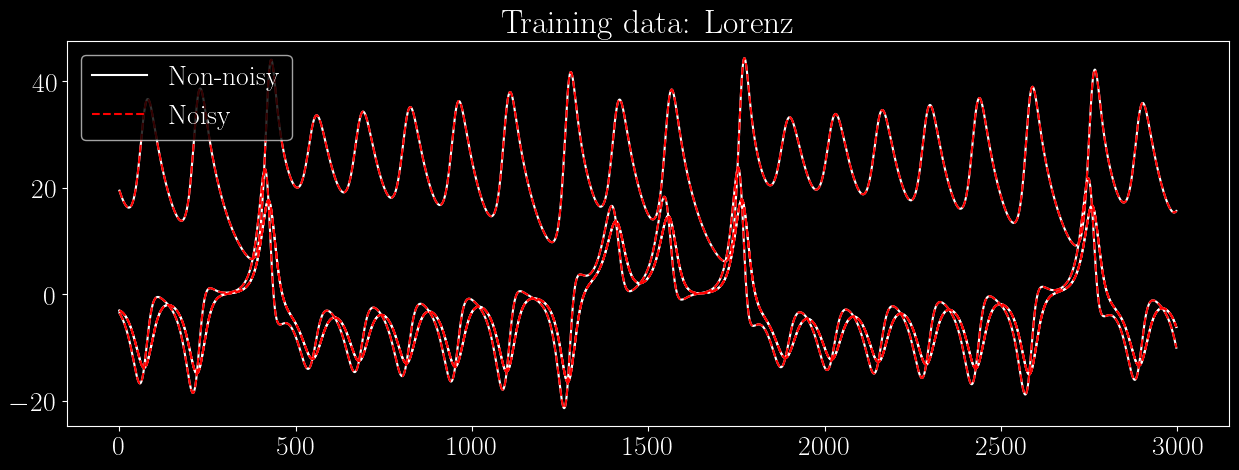

In [23]:
# Data generation parameters
upsample        = 1                     # To increase the dt of the ESN wrt the numerical integrator
dt              = 5e-3 * upsample       # Time step
params          = [8/3, 28, 10]         # Parameters for the Lorenz system

# Define N for washout, training, validation and testing
N_washout       = 100
N_train         = 3000
N_test          = 1000
N_sets          = [N_washout, N_train, N_test]

# Instantiate the solver object
lor3 = Lorenz(params, dt, N_sets, noise=1e-4)
lor3.generate(override=True)            # Can always be regenerated with an Autoencoder

#### CRCM for Lorenz system

Closed Loop: 100%|██████████| 999/999 [00:00<00:00, 4460.11it/s]


MSE: 392099.7796560455


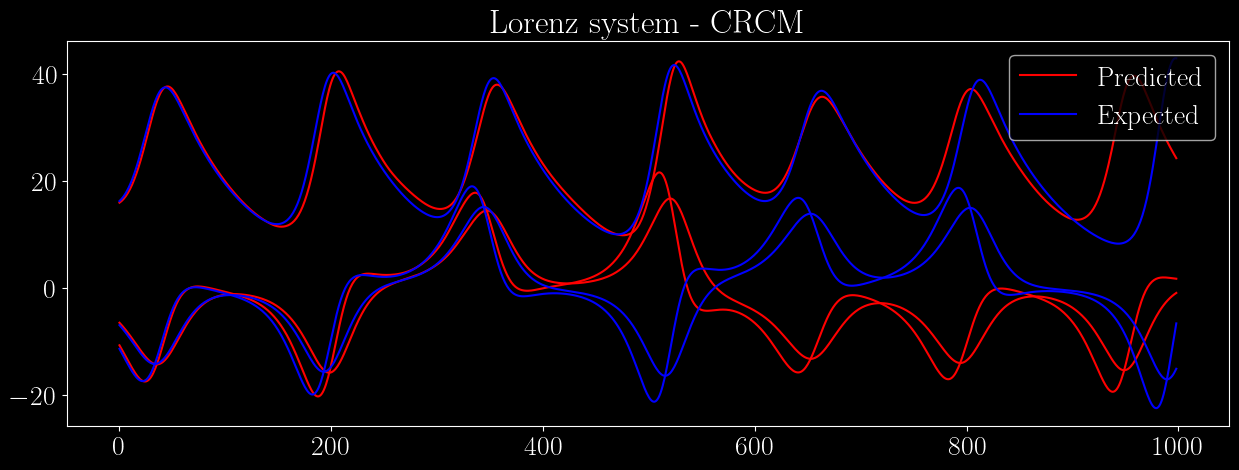

In [24]:
# Initialise the ESN
crcm = CRCM(solver=lor3,
            N_units=500,
            connectivity=10,
            eps= 5e-2,
            tik= 1e-4,
            # sigmoid
            activation=lambda x: 1/(1+np.exp(-x)),
            seed=0)
# Train the ESN with the training data
crcm.train()
crcm.forward()

#### QRCM for Lorenz system

Closed Loop: 100%|██████████| 999/999 [00:35<00:00, 28.03it/s]


MSE: 1050023.9736679173


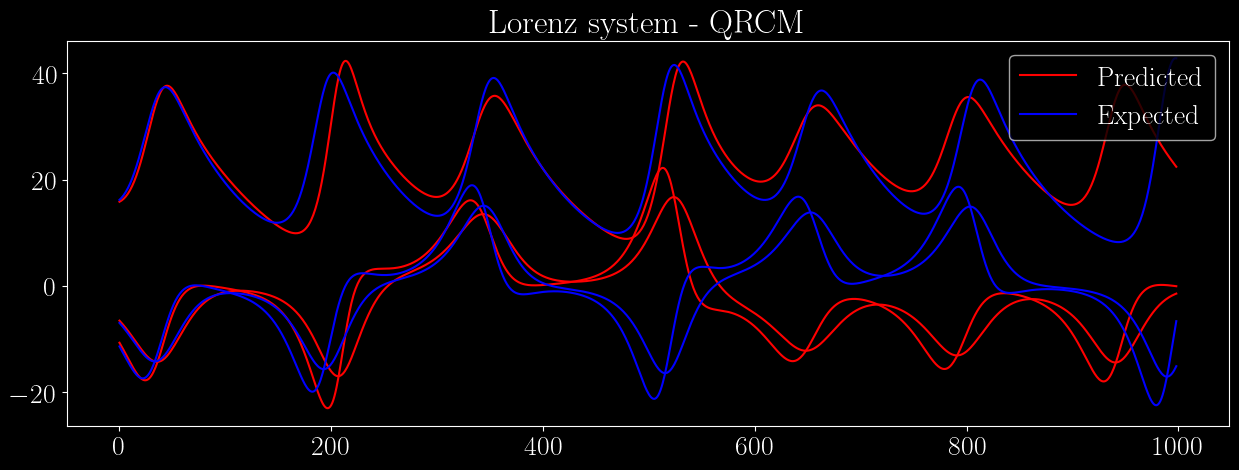

In [25]:
# Instantiate the QRCM object
qrcm = QRCM(solver  = lor3,
            qubits  = 3,
            eps     = 5e-2,
            tik     = 1e-4,
            plot    = True)

# Train the QRCM with the training data
qrcm.train()
qrcm.forward()